# Sprint 2: Schema Design

#### Initial configuration and conection to duckdb and ducklake

In [3]:
import duckdb
import pandas as pd
import os
import glob

# --- 1. Configuration & Paths ---
RAW_DATA_PATH = '../data/raw/'
LAKEHOUSE_PATH = '../data/lakehouse'
METADATA_PATH = os.path.join(LAKEHOUSE_PATH, 'metadata.duckdb')

# Create the base directory if it doesn't exist
os.makedirs(LAKEHOUSE_PATH, exist_ok=True)

# --- 2. Initialize DuckDB & Load DuckLake Extension ---
# Connect to in-memory DuckDB (Compute Layer)
con = duckdb.connect(database=':memory:')

print("--- Initializing DuckLake Extension ---")

# ✅ ACTIVATE DUCKLAKE: This downloads/installs the extension if missing
# and loads it into the current session.
try:
    con.execute("INSTALL ducklake;")
    con.execute("LOAD ducklake;")
    print("✅ Extension 'ducklake' loaded successfully.")
except Exception as e:
    print(f"❌ Error loading 'ducklake'. Make sure the extension is available in your environment.\nError: {e}")

--- Initializing DuckLake Extension ---
✅ Extension 'ducklake' loaded successfully.


#### Attach the Catalog and Schema Management

In [5]:
# --- 3. Attach the Catalog ---
# We attach the persistent storage. 
# Note: Depending on your specific DuckLake version, the syntax for ATTACH might vary slightly.
# This assumes standard syntax where we point to the metadata file.
con.execute(f"ATTACH 'ducklake:{METADATA_PATH}' AS lakehouse")
print(f"✅ Lakehouse catalog attached at: {METADATA_PATH}")

# --- 4. Schema Management ---
# Create logical schemas within the managed catalog
schemas = ['bronze', 'silver', 'gold']
for schema in schemas:
    con.execute(f"CREATE SCHEMA IF NOT EXISTS lakehouse.{schema}")
print(f"✅ Schemas ready: {', '.join(schemas)}")

✅ Lakehouse catalog attached at: ../data/lakehouse\metadata.duckdb
✅ Schemas ready: bronze, silver, gold


---
# Bronze Layer

#### Create table of mobility without data

In [3]:
# --- 5. Ingestion: Mobility Data (Bronze Layer) ---
mitma_raw_glob_path = os.path.join(RAW_DATA_PATH, 'mitma', '*_Viajes_municipios.csv.gz')
mobility_files = glob.glob(mitma_raw_glob_path)

print(f"\n--- Ingesting Mobility Data ---")
if not mobility_files:
    print("❌ No mobility files found!")
else:
    print(f"-> Found {len(mobility_files)} files.")
    
    # Use CREATE TABLE to let DuckLake manage the data
    # This creates a transaction, writes the Parquet files, and updates metadata.
    query_mobility = f"""
        CREATE OR REPLACE TABLE lakehouse.bronze.mobility_sample_week 
        AS
        SELECT 
            *,
            CURRENT_TIMESTAMP AS ingestion_timestamp,
            'https://www.transportes.gob.es/ministerio/proyectos-singulares/estudios-de-movilidad-con-big-data/opendata-movilidad' AS source_url
        FROM read_csv_auto({mobility_files}, filename=true, all_varchar=true)
        LIMIT 0;
    """
    con.execute(query_mobility)
    print(f"✅ Table created: lakehouse.bronze.mobility_sample_week ")


--- Ingesting Mobility Data ---
-> Found 7 files.
✅ Table created: lakehouse.bronze.mobility_sample_week 


#### Creating partition for mobility date

In [4]:
con.execute(f"""
        ALTER TABLE lakehouse.bronze.mobility_sample_week  
        SET PARTITIONED BY (fecha);
    """)

#### Inserting the data into the partitioned table

In [5]:
query_mobility = f"""
    INSERT INTO lakehouse.bronze.mobility_sample_week 
    SELECT 
        *,
        CURRENT_TIMESTAMP AS ingestion_timestamp,
        'https://www.transportes.gob.es/ministerio/proyectos-singulares/estudios-de-movilidad-con-big-data/opendata-movilidad' AS source_url
    FROM read_csv_auto({mobility_files}, filename=true, all_varchar=true);
"""
con.execute(query_mobility)
print(f"✅ Transformed & Ingested: lakehouse.bronze.mobility_sample_week ")

✅ Transformed & Ingested: lakehouse.bronze.mobility_sample_week 


#### Data and Schema Preview of Mobility Files

In [12]:
# --- INSPECTION & METADATA CHECK ---
print("\n--- 🔍 INSPECTION: Mobility Table ---")

# 1. Content Preview
# Verify that 'origen' and 'destino' columns look like municipal codes (5 digits)
print("\n[1] Data Preview (First 5 rows):")
con.execute("SELECT * FROM lakehouse.bronze.mobility_sample_week  LIMIT 5").df()


--- 🔍 INSPECTION: Mobility Table ---

[1] Data Preview (First 5 rows):


,fecha,periodo,origen,destino,distancia,actividad_origen,actividad_destino,estudio_origen_posible,estudio_destino_posible,residencia,renta,edad,sexo,viajes,viajes_km,filename,ingestion_timestamp,source_url
0,20230508,00,39052,39052,2-10,frecuente,casa,no,no,39,10-15,25-45,NA,3.955,28.646,../data/raw/mitma\\20230508_Viajes_municipios....,2025-11-26 20:19:44.727517+01:00,https://www.transportes.gob.es/ministerio/proy...
1,20230508,00,39052,39052,2-10,frecuente,casa,no,no,39,10-15,45-65,NA,5.136,29.855,../data/raw/mitma\\20230508_Viajes_municipios....,2025-11-26 20:19:44.727517+01:00,https://www.transportes.gob.es/ministerio/proy...
2,20230508,00,39052,39052,2-10,frecuente,casa,no,no,39,10-15,NA,NA,97.557,373.901,../data/raw/mitma\\20230508_Viajes_municipios....,2025-11-26 20:19:44.727517+01:00,https://www.transportes.gob.es/ministerio/proy...
3,20230508,00,39052,39052,2-10,frecuente,frecuente,no,no,39,10-15,NA,NA,2.665,13.309,../data/raw/mitma\\20230508_Viajes_municipios....,2025-11-26 20:19:44.727517+01:00,https://www.transportes.gob.es/ministerio/proy...
4,20230508,00,39052,39052,2-10,no_frecuente,casa,no,no,39,10-15,0-25,NA,18.729,84.529,../data/raw/mitma\\20230508_Viajes_municipios....,2025-11-26 20:19:44.727517+01:00,https://www.transportes.gob.es/ministerio/proy...


In [7]:
# 2. Schema Check
# Confirm column names and ensure types are currently VARCHAR (as expected for Bronze)
print("\n[2] Schema (Columns & Types):")
con.execute("DESCRIBE lakehouse.bronze.mobility_sample_week ").df()


[2] Schema (Columns & Types):


,column_name,column_type,null,key,default,extra
0,fecha,VARCHAR,YES,None,None,None
1,periodo,VARCHAR,YES,None,None,None
2,origen,VARCHAR,YES,None,None,None
3,destino,VARCHAR,YES,None,None,None
4,distancia,VARCHAR,YES,None,None,None
5,actividad_origen,VARCHAR,YES,None,None,None
6,actividad_destino,VARCHAR,YES,None,None,None
7,estudio_origen_posible,VARCHAR,YES,None,None,None
8,estudio_destino_posible,VARCHAR,YES,None,None,None
9,residencia,VARCHAR,YES,None,None,None


In [6]:
# 3. Quality Profile
# Check for 100% nulls or weird values. This might take a moment.
print("\n[3] Data Quality Profile (Nulls & Unique Values):")
con.execute("SUMMARIZE lakehouse.bronze.mobility_sample_week ").df()


[3] Data Quality Profile (Nulls & Unique Values):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,fecha,VARCHAR,20230508,20230514,7,None,<NA>,None,None,None,84401339,0.0
1,periodo,VARCHAR,00,23,24,None,<NA>,None,None,None,84401339,0.0
2,origen,VARCHAR,01001,externo,2307,None,<NA>,None,None,None,84401339,0.0
3,destino,VARCHAR,01001,externo,2307,None,<NA>,None,None,None,84401339,0.0
4,distancia,VARCHAR,0.5-2,>50,4,None,<NA>,None,None,None,84401339,0.0
5,actividad_origen,VARCHAR,casa,trabajo_estudio,4,None,<NA>,None,None,None,84401339,0.0
6,actividad_destino,VARCHAR,casa,trabajo_estudio,4,None,<NA>,None,None,None,84401339,0.0
7,estudio_origen_posible,VARCHAR,no,si,2,None,<NA>,None,None,None,84401339,0.0
8,estudio_destino_posible,VARCHAR,no,si,2,None,<NA>,None,None,None,84401339,0.0
9,residencia,VARCHAR,01,52,52,None,<NA>,None,None,None,84401339,0.0


#### Ingesting other tables

In [6]:
# --- 6. Ingestion: Auxiliary Tables (Refactorizado con Linaje) ---

# Define URLs 
URL_MITMA = "https://www.transportes.gob.es/ministerio/proyectos-singulares/estudios-de-movilidad-con-big-data/opendata-movilidad"
URL_INE = "https://www.ine.es/"
URL_CNIG = "https://centrodedescargas.cnig.es/CentroDescargas/index.jsp"
URL_MTDFP = "https://datos.gob.es/es/catalogo/l01280796-calendario-laboral"

def ingest_dimension(table_name, filename, source_url, folder='mitma', sep=';', encoding='utf-8', **kwargs):
    path = os.path.join(RAW_DATA_PATH, folder, filename)
    
    if os.path.exists(path):
        # Escape single quotes in the URL for SQL safety
        safe_url = source_url.replace("'", "''")

        options = f"all_varchar=true, sep='{sep}', encoding='{encoding}'"

        for key, value in kwargs.items():
            # Handle boolean SQL syntax (true/false instead of True/False)
            if isinstance(value, bool):
                sql_val = str(value).lower()
            else:
                sql_val = f"'{value}'"
            options += f", {key}={sql_val}"
            
        print(f"-> Ingesting {table_name} with options: [{options}]")
        
        # Read the CSV and append audit columns
        # We use robust typing (try_cast/all_varchar) to prevent failures if any numeric column contains irregular characters
        con.execute(f"""
            CREATE OR REPLACE TABLE lakehouse.bronze.{table_name} AS
            SELECT 
                *,
                CURRENT_TIMESTAMP AS ingestion_timestamp,
                '{safe_url}' AS source_url
            FROM read_csv_auto('{path}', {options});
        """)
        print(f"✅ Ingested: lakehouse.bronze.{table_name} (Source: {source_url})")
    else:
        print(f"⚠️ Missing file: {filename}")

print("\n--- Ingesting Dictionaries & Dimensions ---")

# 1. Nombres de Distritos (MITMA)
# Fuente: Open Data Movilidad
ingest_dimension('zoning_municipalities', 'nombres_municipios.csv', source_url=URL_MITMA, folder='mitma', sep='|', header=True)

# 2. Población por Distrito (MITMA)
# Fuente: Open Data Movilidad
ingest_dimension('population_municipalities', 'poblacion_municipios.csv', source_url=URL_MITMA, folder='mitma', sep='|')

# 3. Relación Zonificación MITMA <-> INE
# Fuente: Open Data Movilidad
ingest_dimension('mapping_ine_mitma', 'relacion_ine_zonificacionMitma.csv', source_url=URL_MITMA, folder='mitma', sep='|')

# 4. Renta Media (INE)
# Fuente: Instituto Nacional de Estadística
ingest_dimension('ine_rent_municipalities', 'ine_renta.csv', source_url=URL_INE, folder='ine', sep=';')

# 5. Coordenadas Municipales (IGN/CNIG)
# Fuente: Centro de Descargas del CNIG
ingest_dimension('municipal_coordinates', 'municipios_coordenadas.csv', source_url=URL_CNIG, folder='ine', sep=';')

# 6. Calendarios Laborales (MTDFP)
# Fuente: Centro de Descargas del MTDFP
ingest_dimension('work_calendars', 'calendario.csv', source_url=URL_MTDFP, folder='ine', sep=';')


--- Ingesting Dictionaries & Dimensions ---
-> Ingesting zoning_municipalities with options: [all_varchar=true, sep='|', encoding='utf-8', header=true]
✅ Ingested: lakehouse.bronze.zoning_municipalities (Source: https://www.transportes.gob.es/ministerio/proyectos-singulares/estudios-de-movilidad-con-big-data/opendata-movilidad)
-> Ingesting population_municipalities with options: [all_varchar=true, sep='|', encoding='utf-8']
✅ Ingested: lakehouse.bronze.population_municipalities (Source: https://www.transportes.gob.es/ministerio/proyectos-singulares/estudios-de-movilidad-con-big-data/opendata-movilidad)
-> Ingesting mapping_ine_mitma with options: [all_varchar=true, sep='|', encoding='utf-8']
✅ Ingested: lakehouse.bronze.mapping_ine_mitma (Source: https://www.transportes.gob.es/ministerio/proyectos-singulares/estudios-de-movilidad-con-big-data/opendata-movilidad)
-> Ingesting ine_rent_municipalities with options: [all_varchar=true, sep=';', encoding='utf-8']
✅ Ingested: lakehouse.bron

#### Inspection: Rent Table

In [14]:
# Define the table we want to inspect
target_table = "lakehouse.bronze.population_municipalities"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} LIMIT 5").df()


--- 🔍 INSPECTING: lakehouse.bronze.population_municipalities ---

[1] Content Preview (First 5 rows):


,column0,column1,ingestion_timestamp,source_url
0,01001,2925.0,2025-11-26 20:23:19.546648+01:00,https://www.transportes.gob.es/ministerio/proy...
1,01002,10307.0,2025-11-26 20:23:19.546648+01:00,https://www.transportes.gob.es/ministerio/proy...
2,01004_AM,3005.0,2025-11-26 20:23:19.546648+01:00,https://www.transportes.gob.es/ministerio/proy...
3,01009_AM,4599.0,2025-11-26 20:23:19.546648+01:00,https://www.transportes.gob.es/ministerio/proy...
4,01010,2951.0,2025-11-26 20:23:19.546648+01:00,https://www.transportes.gob.es/ministerio/proy...


In [7]:
# Define the table we want to inspect
target_table = "lakehouse.bronze.work_calendars"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} LIMIT 5").df()


--- 🔍 INSPECTING: lakehouse.bronze.work_calendars ---

[1] Content Preview (First 5 rows):


,Dia,Dia_semana,laborable / festivo / domingo festivo,Tipo de Festivo,Festividad,column5,column6,column7,column8,ingestion_timestamp,source_url
0,01/01/2013,martes,festivo,Festivo nacional,Año Nuevo,None,None,None,None,2025-11-28 12:40:36.725000+01:00,https://datos.gob.es/es/catalogo/l01280796-cal...
1,02/01/2013,miercoles,laborable,None,None,None,None,None,None,2025-11-28 12:40:36.725000+01:00,https://datos.gob.es/es/catalogo/l01280796-cal...
2,03/01/2013,jueves,laborable,None,None,None,None,None,None,2025-11-28 12:40:36.725000+01:00,https://datos.gob.es/es/catalogo/l01280796-cal...
3,04/01/2013,viernes,laborable,None,None,None,None,None,None,2025-11-28 12:40:36.725000+01:00,https://datos.gob.es/es/catalogo/l01280796-cal...
4,05/01/2013,sabado,sabado,None,None,None,None,None,None,2025-11-28 12:40:36.725000+01:00,https://datos.gob.es/es/catalogo/l01280796-cal...


In [15]:
# 2. Schema Metadata (Structure)
# Shows column names and types. Since we used 'all_varchar=true', everything should be VARCHAR.
print("\n[2] Schema Metadata (Columns & Types):")
con.execute(f"DESCRIBE {target_table}").df()


[2] Schema Metadata (Columns & Types):


,column_name,column_type,null,key,default,extra
0,column0,VARCHAR,YES,None,None,None
1,column1,VARCHAR,YES,None,None,None
2,ingestion_timestamp,TIMESTAMP WITH TIME ZONE,YES,None,None,None
3,source_url,VARCHAR,YES,None,None,None


In [16]:
# 3. Quality Profile (Statistics)
# Check 'approx_unique' to see how many municipalities have data
# Check 'null_percentage' to ensure the ingestion didn't fail silently
print("\n[3] Quality Statistics (Nulls & Uniques):")
con.execute(f"SUMMARIZE {target_table}").df()


[3] Quality Statistics (Nulls & Uniques):


,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,column0,VARCHAR,01001,52001,2365,None,<NA>,None,None,None,2618,0.0
1,column1,VARCHAR,10048.0,NA,2385,None,<NA>,None,None,None,2618,0.0
2,ingestion_timestamp,TIMESTAMP WITH TIME ZONE,2025-11-26 20:23:19.546648+01,2025-11-26 20:23:19.546648+01,1,2025-11-26 20:23:19.546648+01,<NA>,2025-11-26 20:23:19.546648+01,2025-11-26 20:23:19.546648+01,2025-11-26 20:23:19.546648+01,2618,0.0
3,source_url,VARCHAR,https://www.transportes.gob.es/ministerio/proy...,https://www.transportes.gob.es/ministerio/proy...,1,None,<NA>,None,None,None,2618,0.0


#### Final Check: table names and schema name

In [17]:
# --- 7. Final Check ---
print("\n--- Current Lakehouse State (Bronze Layer) ---")

# We use the internal system function 'duckdb_tables()'
# This function sees EVERYTHING connected to the current session, regardless of the extension used.
query_check = """
    SELECT table_name, schema_name
    FROM duckdb_tables()
    WHERE database_name = 'lakehouse' 
      AND schema_name = 'bronze';
"""
df_result = con.execute(query_check).df()
print(df_result)


--- Current Lakehouse State (Bronze Layer) ---
                  table_name schema_name
0    ine_rent_municipalities      bronze
1      zoning_municipalities      bronze
2       mobility_sample_week      bronze
3  population_municipalities      bronze
4      municipal_coordinates      bronze
5          mapping_ine_mitma      bronze


---
# Silver Layer

In [ ]:
# con = duckdb.connect(database=':memory:')
# print("✅ Successfully connected.")
# con.execute(f"ATTACH 'ducklake:{METADATA_PATH}' AS lakehouse")
# print(f"✅ Lakehouse catalog attached at: {METADATA_PATH}")

#### Zone table

In [18]:
# Check column names to ensure our JOIN uses the right keys
print("--- Checking Columns ---")
print("Zones (MITMA):", con.execute("DESCRIBE lakehouse.bronze.zoning_municipalities").fetch_df()['column_name'].tolist())
print("Mapping (INE):", con.execute("DESCRIBE lakehouse.bronze.mapping_ine_mitma").fetch_df()['column_name'].tolist())

--- Checking Columns ---
Zones (MITMA): ['column0', 'ID', 'name', 'ingestion_timestamp', 'source_url']
Mapping (INE): ['seccion_ine', 'distrito_ine', 'municipio_ine', 'distrito_mitma', 'municipio_mitma', 'gau_mitma', 'ingestion_timestamp', 'source_url']


In [51]:
print("\n--- Building Silver Table: dim_zones ---")

query_dim_zones = """--sql
    CREATE OR REPLACE TABLE lakehouse.silver.dim_zones AS
    WITH unique_mapping AS (
        -- CRITICAL CHANGE: We GROUP BY the MITMA code.
        -- We take the FIRST (Minimum) INE code found as the 'Representative' code.
        -- This ensures 1 MITMA Zone = 1 Row.
        SELECT DISTINCT 
            CAST(municipio_mitma AS VARCHAR) as mitma_ref,
            MIN(CAST(municipio_ine AS VARCHAR)) as ine_ref
        FROM lakehouse.bronze.mapping_ine_mitma
        WHERE municipio_mitma IS NOT NULL
        GROUP BY municipio_mitma
    ),
    raw_zones AS (
        SELECT 
            TRIM(z.ID) AS mitma_code,
            CASE 
                WHEN TRIM(m.ine_ref) = 'NA' THEN NULL 
                ELSE TRIM(m.ine_ref) 
            END AS ine_code,
            TRIM(z.name) AS zone_name
        FROM lakehouse.bronze.zoning_municipalities z
        LEFT JOIN unique_mapping m 
            ON TRIM(z.ID) = TRIM(m.mitma_ref)
        WHERE z.ID IS NOT NULL AND z.ID != 'ID'
        GROUP BY z.ID, z.name, m.ine_ref
    )
    SELECT
        -- 1. Codes
        ROW_NUMBER() OVER (ORDER BY mitma_code) AS zone_id,
        mitma_code,
        ine_code,
        zone_name,
        'municipal' AS zone_level,
        CURRENT_TIMESTAMP AS processed_at
        
    FROM raw_zones
    ORDER BY zone_id;
"""
con.execute(query_dim_zones)
print("✅ Created: lakehouse.silver.dim_zones")


--- Building Silver Table: dim_zones ---
✅ Created: lakehouse.silver.dim_zones


In [52]:
# Define the table we want to inspect
target_table = "lakehouse.silver.dim_zones"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} LIMIT 5").df()



--- 🔍 INSPECTING: lakehouse.silver.dim_zones ---

[1] Content Preview (First 5 rows):


,zone_id,mitma_code,ine_code,zone_name,zone_level,processed_at
0,670,13058,13058,Moral de Calatrava,municipal,2025-11-28 14:14:15.293000+01:00
1,671,13061,13061,Pedro Muñoz,municipal,2025-11-28 14:14:15.293000+01:00
2,672,13063_AM,13007,Piedrabuena agregacion de municipios,municipal,2025-11-28 14:14:15.293000+01:00
3,673,13064,13064,Poblete,municipal,2025-11-28 14:14:15.293000+01:00
4,674,13065_AM,13065,Porzuna agregacion de municipios,municipal,2025-11-28 14:14:15.293000+01:00


In [21]:
# Check coverage
total = con.execute("SELECT COUNT(*) FROM lakehouse.silver.dim_zones").fetchone()[0]
mapped = con.execute("SELECT COUNT(*) FROM lakehouse.silver.dim_zones WHERE ine_code IS NOT NULL").fetchone()[0]
print(f"-> Statistics: {mapped}/{total} zones have been successfully mapped to INE codes.")

-> Statistics: 2569/2618 zones have been successfully mapped to INE codes.


#### Population table

In [67]:
print("\n--- Building Silver Table: metric_population ---")

query_pop = """
    CREATE OR REPLACE TABLE lakehouse.silver.metric_population AS
    SELECT 
        -- 1. Linking Key (Map column0 -> zone_id)
        z.zone_id,
        
        -- 2. The Metric (Map column1 -> population)
        -- Logic:
        --   a. Cast to Integer
        CAST(TRY_CAST(column1 AS DOUBLE) AS BIGINT) AS population,
        
        -- 3. Metadata
        '2023' AS year,
        CURRENT_TIMESTAMP AS processed_at
        
    FROM lakehouse.bronze.population_municipalities p
        JOIN lakehouse.silver.dim_zones z ON TRIM(p.column0) = z.mitma_code
    
    WHERE 
        -- Filter out empty rows
        column0 IS NOT NULL 
        -- Filter out the header row (if the first row contains text like 'ID' or 'Poblacion')
        AND NOT regexp_matches(column1, '[a-zA-Z]') -- Exclude rows where population contains letters
"""
con.execute(query_pop)
print("✅ Created: lakehouse.silver.metric_population")


--- Building Silver Table: metric_population ---
✅ Created: lakehouse.silver.metric_population


In [18]:
# Define the table we want to inspect
target_table = "lakehouse.silver.metric_population"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} LIMIT 5").df()


--- 🔍 INSPECTING: lakehouse.silver.metric_population ---

[1] Content Preview (First 5 rows):


,zone_id,population,year,processed_at
0,1,2925,2023,2025-11-27 13:34:28.057348+01:00
1,2,10307,2023,2025-11-27 13:34:28.057348+01:00
2,3,3005,2023,2025-11-27 13:34:28.057348+01:00
3,4,4599,2023,2025-11-27 13:34:28.057348+01:00
4,5,2951,2023,2025-11-27 13:34:28.057348+01:00


In [19]:
stats = con.execute("""
    SELECT 
        COUNT(*) as total_rows,
        SUM(population) as total_population_spain
    FROM lakehouse.silver.metric_population
""").fetchone()
print(f"-> Integrity Check: {stats[0]} rows loaded. Total Population: {stats[1]:,}")

-> Integrity Check: 2569 rows loaded. Total Population: 47,385,107


#### Coordinates table

In [65]:
print("\n--- Building Silver Table: dim_coordinates ---")

query_coords = """
    CREATE OR REPLACE TABLE lakehouse.silver.dim_coordinates AS
    SELECT 
        z.zone_id,
        
        -- Coordinates
        TRY_CAST(REPLACE(c.LATITUD_ETRS89, ',', '.') AS DOUBLE) AS latitude,
        TRY_CAST(REPLACE(c.LONGITUD_ETRS89, ',', '.') AS DOUBLE) AS longitude,
        
        CURRENT_TIMESTAMP AS processed_at
        
    FROM lakehouse.bronze.municipal_coordinates c
    
    -- SIMPLE JOIN: Exact string match
    JOIN lakehouse.silver.dim_zones z 
        ON LEFT(c.COD_INE, 5) = z.ine_code 
        
    WHERE z.zone_id IS NOT NULL;
"""

con.execute(query_coords)
print("✅ Created: lakehouse.silver.dim_coordinates")


--- Building Silver Table: dim_coordinates ---
✅ Created: lakehouse.silver.dim_coordinates


In [35]:
# --- CRITICAL CHECK ---
# Let's see if the "Simple Join" worked or if we lost data due to "01001" vs "1001"
total_zones_with_ine = con.execute("SELECT COUNT(*) FROM lakehouse.silver.dim_zones WHERE ine_code IS NOT NULL").fetchone()[0]
matched_coords = con.execute("SELECT COUNT(*) FROM lakehouse.silver.dim_coordinates").fetchone()[0]

print(f"\n[Match Statistics]")
print(f"Zones with INE Codes: {total_zones_with_ine}")
print(f"Zones with Coordinates: {matched_coords}")

if matched_coords < (total_zones_with_ine * 0.5):
    print("⚠️ WARNING: Very low match rate. It is highly likely one table has leading zeros ('01001') and the other does not ('1001').")


[Match Statistics]
Zones with INE Codes: 2569
Zones with Coordinates: 2569


In [37]:
# Define the table we want to inspect
target_table = "lakehouse.silver.dim_coordinates"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table}  LIMIT 5").df()


--- 🔍 INSPECTING: lakehouse.silver.dim_coordinates ---

[1] Content Preview (First 5 rows):


,zone_id,latitude,longitude,processed_at
0,1,42.839812,-2.512437,2025-11-27 13:40:36.804911+01:00
1,2,43.054278,-3.000073,2025-11-27 13:40:36.804911+01:00
2,13,43.051197,-2.565400,2025-11-27 13:40:36.804911+01:00
3,3,43.120844,-3.127917,2025-11-27 13:40:36.804911+01:00
4,10,42.723262,-2.871835,2025-11-27 13:40:36.804911+01:00


#### Rent table

In [70]:
print("\n--- Building Silver Table: metric_ine_rent ---")

query_rent = """
    CREATE OR REPLACE TABLE lakehouse.silver.metric_ine_rent AS
    SELECT 
        -- 1. Master Key (Zone ID from our Dimension)
        z.zone_id,
        
        -- 2. The Metric (Cleaned)
        -- Format: "13.500" -> 13500. Handle "dirty" data (like ".") using TRY_CAST
        CAST(TRY_CAST(REPLACE(r.Total, '.', '') AS DOUBLE) AS BIGINT) AS income_per_capita,
        
        -- 3. Time Reference
        CAST(r.Periodo AS INTEGER) AS year,
        
        -- 4. Metadata
        CURRENT_TIMESTAMP AS processed_at
        
    FROM lakehouse.bronze.ine_rent_municipalities r
    
    -- JOIN Logic: Match Extracted INE Code to Zone INE Code
    -- We split "01001 Name" by space to get "01001"
    JOIN lakehouse.silver.dim_zones z 
        ON split_part(r.Municipios, ' ', 1) = z.ine_code
        
    WHERE 
        -- Filter 1: Only the specific indicator requested
        r."Indicadores de renta media" = 'Renta neta media por persona'
        
        -- Filter 2: Ensure we are at Municipality level (Districts/Sections must be empty/null)
        AND (r.Distritos IS NULL OR r.Distritos = '')
        AND (r.Secciones IS NULL OR r.Secciones = '')
        
        -- Filter 3: Valid data
        AND r.Total IS NOT NULL
        AND z.zone_id IS NOT NULL;
"""
con.execute(query_rent)
print("✅ Created: lakehouse.silver.metric_ine_rent")


--- Building Silver Table: metric_ine_rent ---
✅ Created: lakehouse.silver.metric_ine_rent


In [39]:
# Define the table we want to inspect
target_table = "lakehouse.silver.metric_ine_rent"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Available Years::")
con.execute(f"SELECT year, COUNT(*) as zones FROM lakehouse.silver.metric_ine_rent GROUP BY year").df()


--- 🔍 INSPECTING: lakehouse.silver.metric_ine_rent ---

[1] Available Years::


,year,zones
0,2015,2519
1,2016,2566
2,2017,2566
3,2018,2569
4,2019,2569
5,2020,2569
6,2021,2569
7,2022,2569
8,2023,2569


In [41]:
# Define the table we want to inspect
target_table = "lakehouse.silver.metric_ine_rent"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} ORDER BY zone_id LIMIT 5").df()


--- 🔍 INSPECTING: lakehouse.silver.metric_ine_rent ---

[1] Content Preview (First 5 rows):


,zone_id,income_per_capita,year,processed_at
0,1,16429,2023,2025-11-27 13:41:03.283929+01:00
1,1,15116,2022,2025-11-27 13:41:03.283929+01:00
2,1,14647,2021,2025-11-27 13:41:03.283929+01:00
3,1,13969,2020,2025-11-27 13:41:03.283929+01:00
4,1,14299,2019,2025-11-27 13:41:03.283929+01:00


#### Mobility data table

In [73]:
print("\n--- Building Silver Table: fact_mobility ---")

# 1. Create Empty Table Structure (Partitioned)
query_schema = """
    CREATE OR REPLACE TABLE lakehouse.silver.fact_mobility (
        date DATE,
        hour INTEGER,
        origin_zone_id BIGINT,
        destination_zone_id BIGINT,
        trips DOUBLE,
        trips_km DOUBLE,
        processed_at TIMESTAMP
    );
"""
con.execute(query_schema)

# 2. Configure Partitioning (Crucial for Speed)
con.execute("ALTER TABLE lakehouse.silver.fact_mobility SET PARTITIONED BY (date);")

# 3. Insert Data (Transforming on the fly)
query_insert = """--sql
    INSERT INTO lakehouse.silver.fact_mobility
    SELECT 
        -- 1. Time Dimensions
        strptime(fecha, '%Y%m%d') AS date,
        -- dayofweek(strptime(fecha, '%Y%m%d')) AS day_of_week, -- 0=Sunday, 1=Monday... (DuckDB specific, verify range)
        CAST(periodo AS INTEGER) AS hour,
        
        -- 2. Spatial Dimensions
        zo.zone_id AS origin_zone_id,
        zd.zone_id AS destination_zone_id,
        
        -- 3. Metrics (Spanish Format Handling: 1.200,50 -> 1200.50)
        -- Remove thousands separator (.) then replace decimal comma (,) with dot (.)
        TRY_CAST(REPLACE(REPLACE(viajes, '.', ''), ',', '.') AS DOUBLE) AS trips,
        TRY_CAST(REPLACE(REPLACE(viajes_km, '.', ''), ',', '.') AS DOUBLE) AS trips_km,
        
        -- 4. Audit
        CURRENT_TIMESTAMP AS processed_at
        
    FROM lakehouse.bronze.mobility_sample_week m
        LEFT JOIN lakehouse.silver.dim_zones zo ON TRIM(m.origen) = zo.mitma_code
        LEFT JOIN lakehouse.silver.dim_zones zd ON TRIM(m.destino) = zd.mitma_code

    WHERE viajes IS NOT NULL;
"""

print("-> Processing and Inserting Data (this may take a moment)...")
con.execute(query_insert)
print("✅ Created: lakehouse.silver.fact_mobility")


--- Building Silver Table: fact_mobility ---
-> Processing and Inserting Data (this may take a moment)...
✅ Created: lakehouse.silver.fact_mobility


In [74]:
# Define the table we want to inspect
target_table = "lakehouse.silver.fact_mobility"

print(f"\n--- 🔍 INSPECTING: {target_table} ---")

# 1. Content Preview
# Check if the columns were separated correctly (look for separate columns, not one big text blob)
# Also verify the 'source_url' is correct
print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM {target_table} WHERE origin_zone_id IS NULL LIMIT 5").df()


--- 🔍 INSPECTING: lakehouse.silver.fact_mobility ---

[1] Content Preview (First 5 rows):


,date,hour,origin_zone_id,destination_zone_id,trips,trips_km,processed_at
0,2023-05-08,1,<NA>,323,2386.0,1855404.0,2025-11-28 14:31:12.093
1,2023-05-08,1,<NA>,368,5715.0,22884.0,2025-11-28 14:31:12.093
2,2023-05-08,1,<NA>,458,36.0,65085.0,2025-11-28 14:31:12.093
3,2023-05-08,1,<NA>,689,1347.0,624616.0,2025-11-28 14:31:12.093
4,2023-05-08,1,<NA>,725,162.0,98987.0,2025-11-28 14:31:12.093


In [42]:
# --- QA: Referential Integrity Check ---
# Are there zones in our trips that don't exist in our dictionary?

print("--- 🔍 Checking for Orphan Keys ---")

query_orphans = """
    SELECT 
        m.origin_zone_id,
        COUNT(*) as trip_count
    FROM lakehouse.silver.fact_mobility m
    LEFT JOIN lakehouse.silver.dim_zones z 
        ON m.origin_zone_id = z.zone_id
    WHERE z.zone_id IS NULL
    GROUP BY m.origin_zone_id
    ORDER BY trip_count DESC
    LIMIT 10;
"""

orphans = con.execute(query_orphans).fetch_df()

if orphans.empty:
    print("✅ PERFECT: All origin zones in mobility data exist in dim_zones.")
else:
    print(f"⚠️ WARNING: Found {len(orphans)} zone IDs in mobility data that are MISSING from dim_zones.")
    print("Top missing zones (by trip volume):")
    print(orphans)

--- 🔍 Checking for Orphan Keys ---
⚠️ WARNING: Found 1 zone IDs in mobility data that are MISSING from dim_zones.
Top missing zones (by trip volume):
   origin_zone_id  trip_count
0            <NA>      315097


#### Calendar table


In [54]:
print("\n--- Building Silver Table: 2023_calendar ---")

query_rent = """--sql
    CREATE OR REPLACE TABLE lakehouse.silver.calendar AS
    SELECT 
        -- 1. Fecha
        CAST(strptime("Dia", '%d/%m/%Y') AS DATE) AS date,
        
        -- 2. Traducción de día de la semana (Español -> Inglés)
        CASE dia_semana
            WHEN 'lunes' THEN 'Monday'
            WHEN 'martes' THEN 'Tuesday'
            WHEN 'miercoles' THEN 'Wednesday'
            WHEN 'miércoles' THEN 'Wednesday'
            WHEN 'jueves' THEN 'Thursday'
            WHEN 'viernes' THEN 'Friday'
            WHEN 'sabado' THEN 'Saturday'
            WHEN 'sábado' THEN 'Saturday'
            WHEN 'domingo' THEN 'Sunday'
            ELSE dia_semana -- Por si acaso hay algún error de escritura, deja el original
        END AS day_of_week,
        
        -- 3. Categoría del día
        CASE 
            WHEN "laborable / festivo / domingo festivo" IN ('Festivo') THEN 'festive'
            WHEN "dia_semana" IN ('sabado', 'domingo') THEN 'weekend'
            ELSE 'weekday' 
        END AS day_category,

    CURRENT_TIMESTAMP AS processed_at

    FROM lakehouse.bronze.work_calendars
    WHERE 
        date_part('year', strptime("Dia", '%d/%m/%Y')) = 2023;
"""
con.execute(query_rent)
print("✅ Created: lakehouse.silver.metric_ine_rent")


--- Building Silver Table: 2023_calendar ---
✅ Created: lakehouse.silver.metric_ine_rent


In [55]:
# Content Preview

print("\n[1] Content Preview (First 5 rows):")
con.execute(f"SELECT * FROM lakehouse.silver.calendar").df()


[1] Content Preview (First 5 rows):


,date,day_of_week,day_category,processed_at
0,2023-01-01,Sunday,weekend,2025-11-28 14:16:48.470000+01:00
1,2023-01-02,Monday,weekday,2025-11-28 14:16:48.470000+01:00
2,2023-01-03,Tuesday,weekday,2025-11-28 14:16:48.470000+01:00
3,2023-01-04,Wednesday,weekday,2025-11-28 14:16:48.470000+01:00
4,2023-01-05,Thursday,weekday,2025-11-28 14:16:48.470000+01:00
...,...,...,...,...
360,2023-12-27,Wednesday,weekday,2025-11-28 14:16:48.470000+01:00
361,2023-12-28,Thursday,weekday,2025-11-28 14:16:48.470000+01:00
362,2023-12-29,Friday,weekday,2025-11-28 14:16:48.470000+01:00
363,2023-12-30,Saturday,weekday,2025-11-28 14:16:48.470000+01:00


#### Information test

In [43]:
query_2023_strict = """
    SELECT 
        z.zone_id,
        z.ine_code,
        z.zone_name,
        p.year,
        p.population,
        r.income_per_capita AS rent,
        c.latitude, 
        c.longitude
        
    FROM lakehouse.silver.dim_zones z
    
    -- 1. Population: Strictly 2023 (Inner Join, as this is our baseline)
    JOIN lakehouse.silver.metric_population p 
        ON z.zone_id = p.zone_id 
        AND p.year = 2023
        
    -- 2. Rent: Strictly 2023 (Left Join)
    -- If the Rent table has year=2021, this condition fails, and you get NULL (clean exclusion)
    LEFT JOIN lakehouse.silver.metric_ine_rent r 
        ON z.zone_id = r.zone_id 
        AND r.year = 2023
        
    -- 3. Coordinates (Static)
    LEFT JOIN lakehouse.silver.dim_coordinates c 
        ON z.zone_id = c.zone_id
        
    ORDER BY z.zone_id;
"""

print("--- 📊 Consolidated 2023 View ---")
con.execute(query_2023_strict).df()

--- 📊 Consolidated 2023 View ---


,zone_id,ine_code,zone_name,year,population,rent,latitude,longitude
0,1,01001,Alegría-Dulantzi,2023,2925,16429,42.839812,-2.512437
1,2,01002,Amurrio,2023,10307,17486,43.054278,-3.000073
2,3,01004,Artziniega agregacion de municipios,2023,3005,16408,43.120844,-3.127917
3,4,01009,Asparrena agregacion de municipios,2023,4599,17018,42.889688,-2.316708
4,5,01010,Ayala/Aiara,2023,2951,17163,43.077683,-3.043067
...,...,...,...,...,...,...,...,...
2564,2614,50297,Zaragoza,2023,675301,16272,41.656457,-0.879287
2565,2615,50298,Zuera,2023,8591,15070,41.869076,-0.786719
2566,2616,50903,Villamayor de Gállego,2023,2768,16099,41.684198,-0.770533
2567,2617,51001,Ceuta,2023,83517,14625,35.888102,-5.306751


In [35]:
query_2023_strict = """
    SELECT 
        *
    FROM lakehouse.silver.dim_zones z
    WHERE zone_id = '19156_AM'
"""

print("--- 📊 Consolidated 2023 View ---")
con.execute(query_2023_strict).df()

--- 📊 Consolidated 2023 View ---


,zone_id,mitma_code,ine_code,zone_name,processed_at
0,19156_AM,19156_AM,19005,Jadraque agregacion de municipios,2025-11-26 20:23:34.030061+01:00


In [34]:
print("\n--- Current Lakehouse State (Silver Layer) ---")

# We use the internal system function 'duckdb_tables()'
# This function sees EVERYTHING connected to the current session, regardless of the extension used.
query_check = """
    SELECT table_name, schema_name
    FROM duckdb_tables()
    WHERE database_name = 'lakehouse' 
      AND schema_name = 'silver';
"""
df_result = con.execute(query_check).df()
print(df_result)


--- Current Lakehouse State (Silver Layer) ---
          table_name schema_name
0      fact_mobility      silver
1          dim_zones      silver
2  metric_population      silver
3    dim_coordinates      silver
4    metric_ine_rent      silver
5           calendar      silver


## Gold Layer 

### Business Question 1: Typical Day Mobility

In [ ]:
query_create_view = """--sql
CREATE OR REPLACE TABLE lakehouse.gold.daily_average_trips AS (
    WITH dailyhourlypatterns AS (
      -- Step 1: Calculate total trips for each hour of each day
      -- and label the day using the new calendar table.
      SELECT
        f.date,
        f.hour,
        c.day_category AS day_type, 
        SUM(f.trips) AS total_trips_for_hour
      FROM
        lakehouse.silver.fact_mobility f
      -- JOIN: Unimos con la tabla calendario
      JOIN lakehouse.silver.calendar c 
        ON f.date = c.date
      WHERE
        f.date BETWEEN '2023-05-08' AND '2023-05-14'
      GROUP BY
        f.date,
        f.hour,
        c.day_category -- Agrupamos por la columna del calendario
    )
    -- Step 2: Average these hourly totals to find the "typical" pattern
    -- for Weekday vs. Weekend vs. Festivo.
    SELECT
      day_type,
      hour,
      ROUND(AVG(total_trips_for_hour), 0) AS average_hourly_trips
    FROM
      dailyhourlypatterns
    GROUP BY
      day_type,
      hour
    ORDER BY
      day_type,
      hour
);
"""

con.execute(query_create_view)


#We can plot the dataframe we gust generated
query_select = "SELECT * FROM lakehouse.gold.daily_average_trips LIMIT 5"

display(con.execute(query_select).df())


,day_type,hour,average_hourly_trips
0,weekday,0,2.671138e+09
1,weekday,1,1.487376e+09
2,weekday,2,1.026955e+09
3,weekday,3,8.417671e+08
4,weekday,4,9.236444e+08


Querying typical day demand data...
Pivoting data for plotting...
Generating plot with matplotlib...


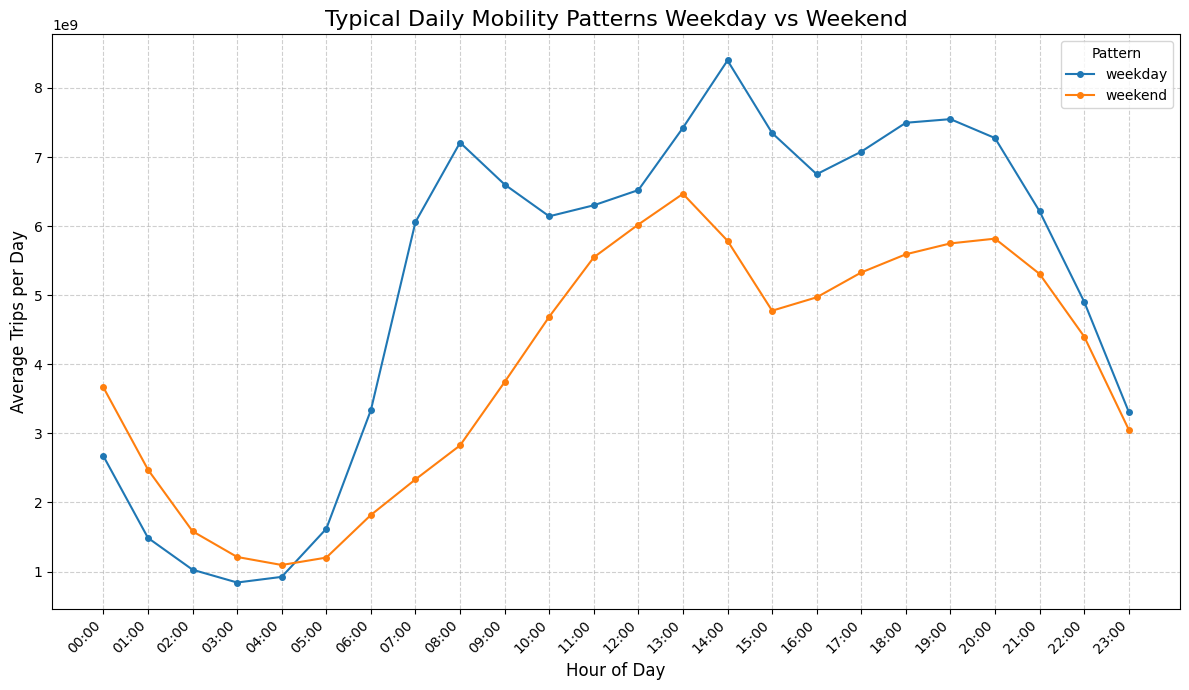

In [41]:
import matplotlib.pyplot as plt

# --- Query the data for plotting ---
print("Querying typical day demand data...")
query = """
SELECT 
    *
FROM lakehouse.gold.daily_average_trips
"""
demand_df = con.execute(query).df()



if demand_df.empty:
    print("ERROR: 'gold.typical_day_demand' table is empty. No data to plot.")
else:
    # --- Prepare data for plotting ---
    print("Pivoting data for plotting...")
    pivot_df = demand_df.pivot(index='hour', columns='day_type', values='average_hourly_trips')
    
    # --- Create the plot ---
    print("Generating plot with matplotlib...")
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Plot the data
    pivot_df.plot(kind='line', ax=ax, marker='o', markersize=4)
    
    ax.set_title('Typical Daily Mobility Patterns Weekday vs Weekend', fontsize=16)
    ax.set_xlabel('Hour of Day', fontsize=12)
    ax.set_ylabel('Average Trips per Day', fontsize=12)
    
    # Set x-ticks to be clear
    ax.set_xticks(range(0, 24))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45, ha='right')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Add legend
    ax.legend(title='Pattern')
    
    # Ensure labels are not cut off
    plt.tight_layout()
    
    
    # Display the plot in the notebook
    plt.show()

### Business Question 2: Infrastructure Gaps

In [ ]:
# Instalar y cargar la extensión espacial
con.execute("INSTALL 'spatial';")
con.execute("LOAD 'spatial';")

In [93]:
print("Creating Gold table 'gold_infrastructure_gaps'...")

# Esta consulta responde a la Pregunta de Negocio 2
gold_bq2_query = """--sql
CREATE OR REPLACE TABLE lakehouse.gold.gold_infrastructure_gaps AS

WITH od_pairs AS (
    SELECT
        origin_zone_id,
        destination_zone_id,
        SUM(trips) AS total_actual_trips
    FROM lakehouse.silver.fact_mobility
    GROUP BY 1, 2
),

model_calculation AS (
    SELECT
        m.origin_zone_id AS org_zone_id,
        m.destination_zone_id AS dest_zone_id,
        p.population AS total_population,                     -- P_i
        r.income_per_capita AS rent,              -- E_j
        m.total_actual_trips AS total_trips,                    -- Viajes reales
        
        -- Calcular distancia (d_ij) en KM usando la extensión espacial
        -- Usamos GREATEST(0.5, ...) para evitar distancias de 0 (ej. viajes en la misma zona)
        -- y así prevenir errores de división por cero.
        GREATEST(
            0.5, -- Distancia mínima de 0.5 km
            st_distance_spheroid(
                st_point(c_org.longitude, c_org.latitude), 
                st_point(c_dest.longitude, c_dest.latitude)
            ) / 1000 -- Convertir metros (salida de st_distance) a KM
        ) AS geographic_distance_km             -- d_ij
            
    FROM od_pairs AS m
    JOIN lakehouse.silver.metric_population AS p ON m.origin_zone_id = p.zone_id
    JOIN lakehouse.silver.metric_ine_rent AS r ON m.destination_zone_id = r.zone_id
    JOIN lakehouse.silver.dim_coordinates as c_org ON m.origin_zone_id = c_org.zone_id
    JOIN lakehouse.silver.dim_coordinates as c_dest ON m.destination_zone_id = c_dest.zone_id

    
    -- Filtramos datos malos para evitar errores en el modelo
    WHERE p.population > 0 
      AND r.income_per_capita > 0
      AND c_org.latitude IS NOT NULL
      AND c_dest.latitude IS NOT NULL
      AND m.origin_zone_id != m.destination_zone_id -- Evitar viajes dentro de la misma zona
)

-- Calcular el modelo final y el mismatch
SELECT
    org_zone_id,
    dest_zone_id,
    total_trips,
    total_population,
    rent,
    geographic_distance_km,
    
    -- Calcular Modelo de Gravedad T_ij = k * (P_i * E_j) / (d_ij^2)
    -- Asumimos k=1 para este PoC del Sprint 1
    (1.0 * (CAST(total_population AS DOUBLE) * CAST(rent AS DOUBLE))) / 
    (geographic_distance_km * geographic_distance_km) AS estimated_potential_trips, -- T_ij
        
    -- Calcular Mismatch Ratio 
    -- (Viajes Reales / Viajes Estimados)
    total_trips / NULLIF(estimated_potential_trips, 0) AS mismatch_ratio

FROM model_calculation;
"""

con.execute(gold_bq2_query)
print("✓ Tabla 'gold.gold_infrastructure_gaps' creada.")

# --- Verificación ---
print("\n--- Verificación BQ2: Top 10 Zonas con 'Mismatch' (potencialmente peor servidas) ---")
verification_bq2 = """--sql
    SELECT 
        org_zone_id,
        dest_zone_id,
        total_trips,
        estimated_potential_trips,
        geographic_distance_km,
        mismatch_ratio
    FROM lakehouse.gold.gold_infrastructure_gaps
    WHERE total_trips > 10 -- Filtrar pares con muy pocos viajes
    AND org_zone_id != dest_zone_id -- Evitar viajes dentro de la misma zona
    ORDER BY mismatch_ratio ASC -- Ordenamos por ratio más bajo (peor servicio)
    LIMIT 10;
"""
display(con.execute(verification_bq2).df())

Creating Gold table 'gold_infrastructure_gaps'...
✓ Tabla 'gold.gold_infrastructure_gaps' creada.

--- Verificación BQ2: Top 10 Zonas con 'Mismatch' (potencialmente peor servidas) ---


,org_zone_id,dest_zone_id,total_trips,estimated_potential_trips,geographic_distance_km,mismatch_ratio
0,1572,2365,25.0,243831.417200,156.610206,0.000103
1,2614,473,11.0,104129.203081,322.153702,0.000106
2,385,318,22.0,208055.835441,47.188730,0.000106
3,1572,2365,25.0,230204.936645,156.610206,0.000109
4,385,318,22.0,196567.514575,47.188730,0.000112
5,1572,2365,25.0,217704.611508,156.610206,0.000115
6,2614,473,11.0,95774.401059,322.153702,0.000115
7,385,318,22.0,187072.065696,47.188730,0.000118
8,1572,2365,25.0,209708.908042,156.610206,0.000119
9,412,859,40.0,332770.130298,36.329347,0.000120


In [96]:
print("\n--- Verificación BQ2: Top 10 Zonas con 'Mismatch' (potencialmente peor servidas) ---")
verification_bq2 = """--sql
    SELECT 
        org_zone_id,
        dest_zone_id,
        total_trips,
        estimated_potential_trips,
        geographic_distance_km,
        mismatch_ratio
    FROM lakehouse.gold.gold_infrastructure_gaps
    WHERE total_trips > 10 -- Filtrar pares con muy pocos viajes
    ORDER BY mismatch_ratio ASC -- Ordenamos por ratio más bajo (peor servicio)
    LIMIT 15;
"""
display(con.execute(verification_bq2).df())


--- Verificación BQ2: Top 10 Zonas con 'Mismatch' (potencialmente peor servidas) ---


,org_zone_id,dest_zone_id,total_trips,estimated_potential_trips,geographic_distance_km,mismatch_ratio
0,1572,2365,25.0,243831.417200,156.610206,0.000103
1,2614,473,11.0,104129.203081,322.153702,0.000106
2,385,318,22.0,208055.835441,47.188730,0.000106
3,1572,2365,25.0,230204.936645,156.610206,0.000109
4,385,318,22.0,196567.514575,47.188730,0.000112
5,1572,2365,25.0,217704.611508,156.610206,0.000115
6,2614,473,11.0,95774.401059,322.153702,0.000115
7,385,318,22.0,187072.065696,47.188730,0.000118
8,1572,2365,25.0,209708.908042,156.610206,0.000119
9,412,859,40.0,332770.130298,36.329347,0.000120


In [97]:
con.close()